In [1]:
!python -m pip install --user --upgrade pip

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
!pip install statsmodels==0.13.2

In [1]:
import warnings
warnings.filterwarnings('ignore') # warning 무시

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#dataframe 관련 option
pd.options.display.float_format = '{:,.2f}'.format # 소수점 2번째 짜리까지 표기.
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split # selection

# 성능평가 for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

In [2]:
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61


Feature Engineering: 데이터에서 시계열패턴 추출하기

In [3]:
raw_all.describe(include='all').T # include="all" : 문자열을 포함한 모든 describe

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,17379,17379,2011-01-01 0:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,379.00",NaN,NaN,NaN,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,379.00",NaN,NaN,NaN,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,379.00",NaN,NaN,NaN,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,379.00",NaN,NaN,NaN,1.43,0.64,1.00,1.00,1.00,2.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...
humidity,"17,379.00",NaN,NaN,NaN,62.72,19.29,0.00,48.00,63.00,78.00,100.00
windspeed,"17,379.00",NaN,NaN,NaN,12.74,8.20,0.00,7.00,13.00,17.00,57.00
casual,"17,379.00",NaN,NaN,NaN,35.68,49.31,0.00,4.00,17.00,48.00,367.00
registered,"17,379.00",NaN,NaN,NaN,153.79,151.36,0.00,34.00,115.00,220.00,886.00


In [4]:
raw_all.shape

(17379, 12)

In [5]:
raw_all.ndim

2

In [6]:
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      17379 non-null  int64  
 10  registered  17379 non-null  int64  
 11  count       17379 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.6+ MB


datetime object -> type 변경

In [7]:
raw_all['datetime']

0         2011-01-01 0:00
1         2011-01-01 1:00
2         2011-01-01 2:00
3         2011-01-01 3:00
4         2011-01-01 4:00
               ...       
17374    2012-12-31 19:00
17375    2012-12-31 20:00
17376    2012-12-31 21:00
17377    2012-12-31 22:00
17378    2012-12-31 23:00
Name: datetime, Length: 17379, dtype: object

In [8]:
pd.to_datetime(raw_all['datetime'])

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
17374   2012-12-31 19:00:00
17375   2012-12-31 20:00:00
17376   2012-12-31 21:00:00
17377   2012-12-31 22:00:00
17378   2012-12-31 23:00:00
Name: datetime, Length: 17379, dtype: datetime64[ns]

In [9]:
# string to datetime
if 'datetime' in raw_all.columns:
    raw_all['datetime'] = pd.to_datetime(raw_all['datetime'])
    raw_all['DateTime'] = pd.to_datetime(raw_all['datetime'])
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   holiday     17379 non-null  int64         
 3   workingday  17379 non-null  int64         
 4   weather     17379 non-null  int64         
 5   temp        17379 non-null  float64       
 6   atemp       17379 non-null  float64       
 7   humidity    17379 non-null  int64         
 8   windspeed   17379 non-null  float64       
 9   casual      17379 non-null  int64         
 10  registered  17379 non-null  int64         
 11  count       17379 non-null  int64         
 12  DateTime    17379 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(8)
memory usage: 1.7 MB


In [10]:
raw_all.index.dtype

dtype('int64')

In [11]:
if raw_all.index.dtype == 'int64':
    raw_all.set_index('DateTime', inplace=True) # inplace = true : 실제값이 바뀌게
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90


In [12]:
raw_all.describe(include='all').T
raw_all.isnull()
raw_all.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
             ..
humidity      0
windspeed     0
casual        0
registered    0
count         0
Length: 12, dtype: int64

## freq 설정

In [13]:
raw_all.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=17379, freq=None)

In [14]:
raw_all.asfreq('H')
raw_all.asfreq('H').index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=17544, freq='H')

In [15]:
raw_all.asfreq('H').isnull().sum() # freq 설정하면서 생기는 NaN

datetime      165
season        165
holiday       165
workingday    165
weather       165
             ... 
humidity      165
windspeed     165
casual        165
registered    165
count         165
Length: 12, dtype: int64

In [16]:
raw_all.asfreq('H')[raw_all.asfreq('H').isnull().sum(axis=1) > 0]
# 데이터가 없던 column들..

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-02 05:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-30 12:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-08 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-29 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
raw_all.index
raw_all.asfreq('D')
raw_all.asfreq('W')
raw_all.asfreq('H')
raw_all.asfreq('H').head(100)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1.00,0.00,0.00,1.00,9.84,14.39,81.00,0.00,3.00,13.00,16.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1.00,0.00,0.00,1.00,9.02,13.63,80.00,0.00,8.00,32.00,40.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1.00,0.00,0.00,1.00,9.02,13.63,80.00,0.00,5.00,27.00,32.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1.00,0.00,0.00,1.00,9.84,14.39,75.00,0.00,3.00,10.00,13.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1.00,0.00,0.00,1.00,9.84,14.39,75.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-04 23:00:00,2011-01-04 23:00:00,1.00,0.00,1.00,1.00,8.20,11.37,69.00,6.00,2.00,9.00,11.00
2011-01-05 00:00:00,2011-01-05 00:00:00,1.00,0.00,1.00,1.00,8.20,12.88,64.00,0.00,0.00,6.00,6.00
2011-01-05 01:00:00,2011-01-05 01:00:00,1.00,0.00,1.00,1.00,6.56,9.85,74.00,6.00,0.00,6.00,6.00


In [18]:
# NaN 보간 ffill = forward fill 
raw_all = raw_all.asfreq('H', method='ffill')
raw_all.isnull().sum()
raw_all.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=17544, freq='H')

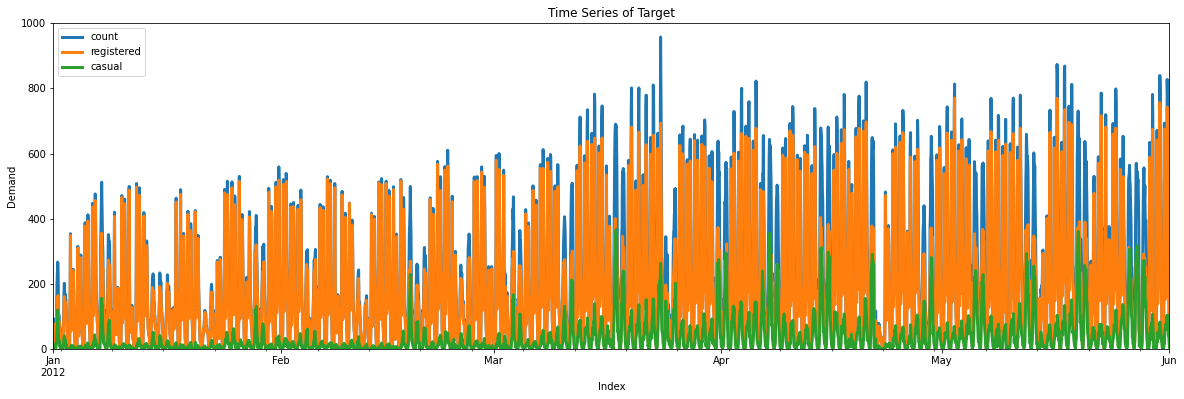

In [25]:
raw_all[['count','registered','casual']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=10,
                                              xlim=('2012-01-01', '2012-06-01'), ylim=(0,1000))
plt.title('Time Series of Target')
plt.xlabel('Index')
plt.ylabel('Demand')
plt.show()

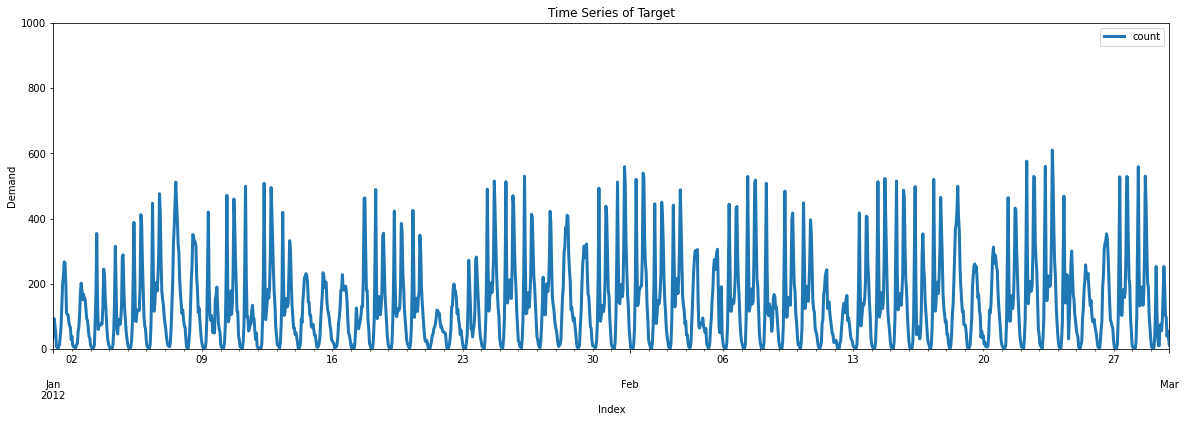

In [23]:
# line plot of Y
raw_all[['count']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=10, xlim=('2012-01-01', '2012-03-01'), ylim=(0,1000))
plt.title('Time Series of Target')
plt.xlabel('Index')
plt.ylabel('Demand')
plt.show()

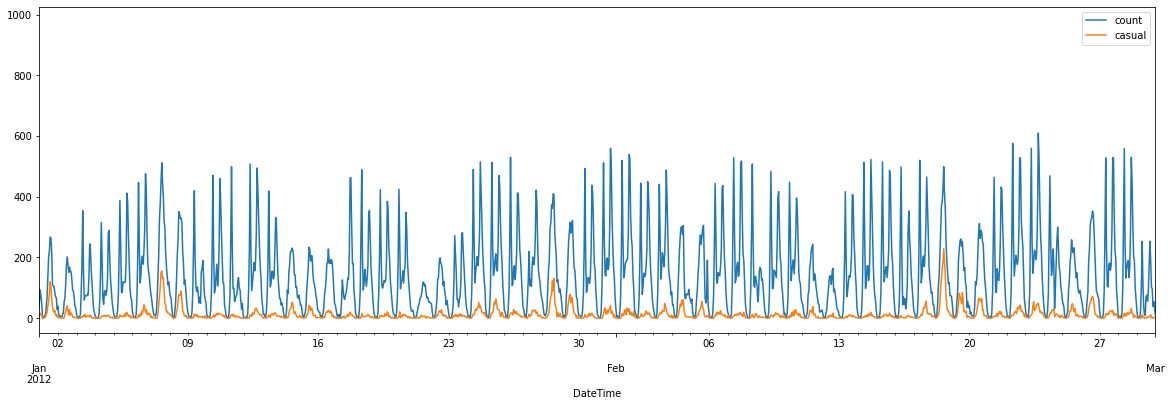

In [43]:
# line plot of Y
raw_all[['count','casual']].plot(kind='line', figsize=(20,6), fontsize=10, xlim=('2012-01-01', '2012-03-01'))
plt.show()

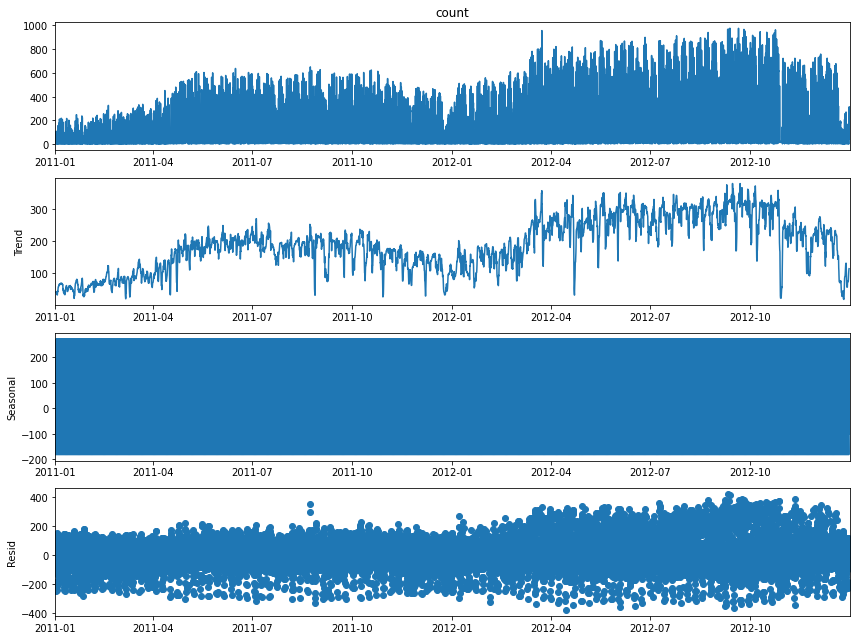

In [47]:
# split data as trend + seasonal + residual
plt.rcParams['figure.figsize'] = (12, 9)
sm.tsa.seasonal_decompose(raw_all['count'], model='additive').plot()
plt.show()

In [49]:
result = sm.tsa.seasonal_decompose(raw_all['count'], model='additive')
result.trend[:20]

DateTime
2011-01-01 00:00:00     NaN
2011-01-01 01:00:00     NaN
2011-01-01 02:00:00     NaN
2011-01-01 03:00:00     NaN
2011-01-01 04:00:00     NaN
                       ... 
2011-01-01 15:00:00   39.02
2011-01-01 16:00:00   38.92
2011-01-01 17:00:00   39.00
2011-01-01 18:00:00   39.04
2011-01-01 19:00:00   39.00
Freq: H, Name: trend, Length: 20, dtype: float64

In [50]:
result.seasonal

DateTime
2011-01-01 00:00:00   -134.25
2011-01-01 01:00:00   -154.75
2011-01-01 02:00:00   -165.27
2011-01-01 03:00:00   -176.48
2011-01-01 04:00:00   -181.67
                        ...  
2012-12-31 19:00:00    122.70
2012-12-31 20:00:00     37.48
2012-12-31 21:00:00    -16.10
2012-12-31 22:00:00    -56.94
2012-12-31 23:00:00   -100.31
Freq: H, Name: seasonal, Length: 17544, dtype: float64

In [52]:
pd.DataFrame(result.resid).describe()

,resid
count,"17,520.00"
mean,-0.01
std,99.68
min,-377.73
25%,-61.00
50%,-6.01
75%,54.86
max,418.44


In [55]:
Y_trend = pd.DataFrame(result.trend)
Y_trend.fillna(method='ffill', inplace=True) # 뒤 쪽 NaN
Y_trend.fillna(method='bfill', inplace=True) # 앞 쪽 NaN
Y_trend[20:]

,trend
DateTime,
2011-01-01 20:00:00,38.96
2011-01-01 21:00:00,39.08
2011-01-01 22:00:00,39.56
2011-01-01 23:00:00,40.21
2011-01-02 00:00:00,40.69
...,...
2012-12-31 19:00:00,113.71
2012-12-31 20:00:00,113.71
2012-12-31 21:00:00,113.71


In [57]:
Y_trend.columns = ['count_trend']
Y_trend

,count_trend
DateTime,
2011-01-01 00:00:00,41.06
2011-01-01 01:00:00,41.06
2011-01-01 02:00:00,41.06
2011-01-01 03:00:00,41.06
2011-01-01 04:00:00,41.06
...,...
2012-12-31 19:00:00,113.71
2012-12-31 20:00:00,113.71
2012-12-31 21:00:00,113.71


In [58]:
Y_seasonal = pd.DataFrame(result.seasonal)
Y_seasonal.fillna(method='ffill', inplace=True)
Y_seasonal.fillna(method='bfill', inplace=True)
Y_seasonal.columns = ['count_seasonal']
Y_seasonal

,count_seasonal
DateTime,
2011-01-01 00:00:00,-134.25
2011-01-01 01:00:00,-154.75
2011-01-01 02:00:00,-165.27
2011-01-01 03:00:00,-176.48
2011-01-01 04:00:00,-181.67
...,...
2012-12-31 19:00:00,122.70
2012-12-31 20:00:00,37.48
2012-12-31 21:00:00,-16.10


In [59]:
# merging several columns
pd.concat([raw_all, Y_trend, Y_seasonal], axis=1).isnull().sum()

datetime          0
season            0
holiday           0
workingday        0
weather           0
                 ..
casual            0
registered        0
count             0
count_trend       0
count_seasonal    0
Length: 14, dtype: int64

In [60]:
raw_all.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [61]:
if 'count_trend' not in raw_all.columns:
    if 'count_seasonal' not in raw_all.columns:
        raw_all = pd.concat([raw_all, Y_trend, Y_seasonal], axis=1)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal
DateTime,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10


In [62]:
raw_all[['count']].rolling(24).mean() # rolling -> 앞뒤, 주변 24개 데이터의 평균을 알려 달라는 의미.

,count
DateTime,
2011-01-01 00:00:00,NaN
2011-01-01 01:00:00,NaN
2011-01-01 02:00:00,NaN
2011-01-01 03:00:00,NaN
2011-01-01 04:00:00,NaN
...,...
2012-12-31 19:00:00,110.17
2012-12-31 20:00:00,110.88
2012-12-31 21:00:00,112.67


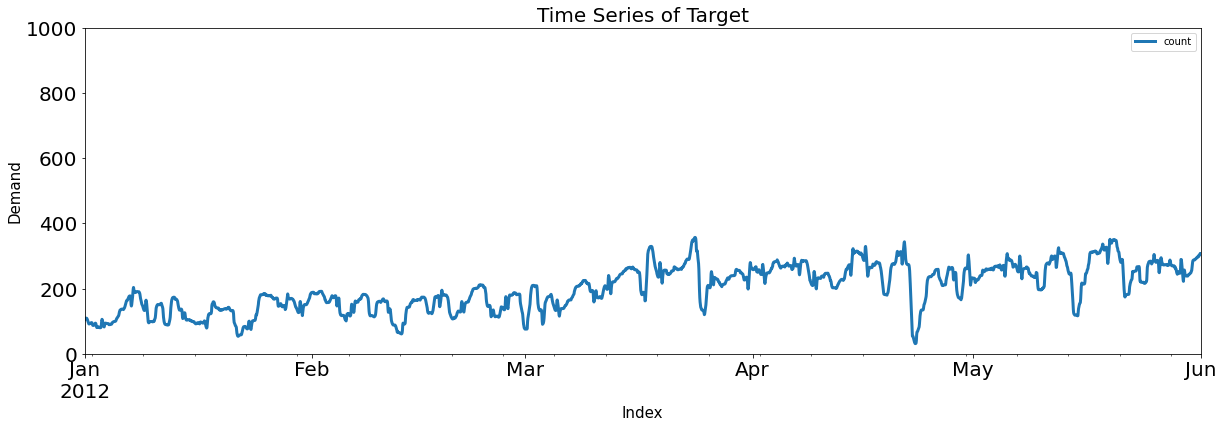

In [63]:
raw_all[['count']].rolling(24).mean().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                             xlim=('2012-01-01', '2012-06-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

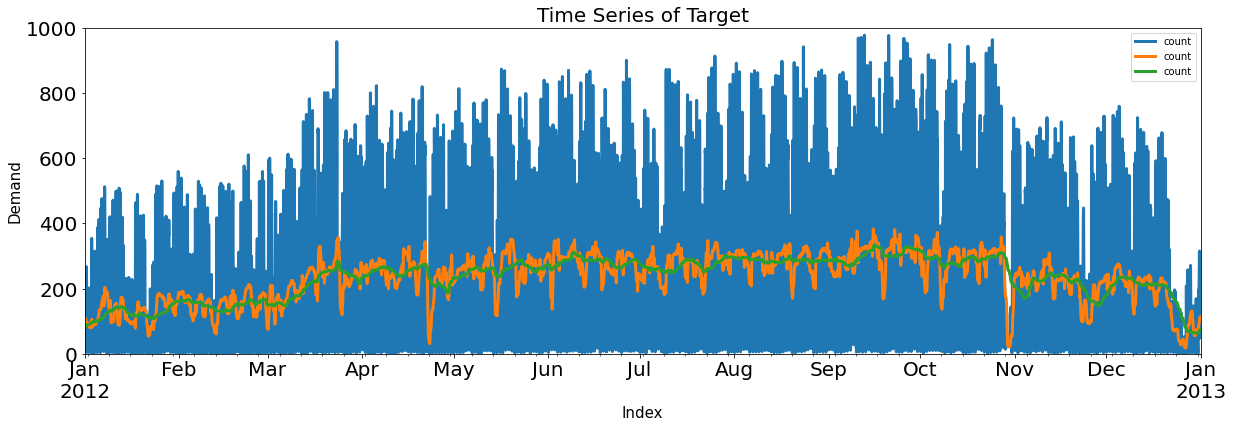

In [64]:
# datetime = 1시간 간격으로 수집 -> rolling(24) - 하루치, rolling(24*7) - 한 주간 패턴을 보겠다는 의미.
pd.concat([raw_all[['count']], 
           raw_all[['count']].rolling(24).mean(),
           raw_all[['count']].rolling(24*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  xlim=('2012-01-01', '2013-01-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [65]:
Y_count_Day = raw_all[['count']].rolling(24).mean()
Y_count_Day.fillna(method='ffill', inplace=True)
Y_count_Day.fillna(method='bfill', inplace=True)
Y_count_Day.columns = ['count_Day']

Y_count_Week = raw_all[['count']].rolling(24*7).mean()
Y_count_Week.fillna(method='ffill', inplace=True)
Y_count_Week.fillna(method='bfill', inplace=True)
Y_count_Week.columns = ['count_Week']

if 'count_Day' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_count_Day], axis=1)
if 'count_Week' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_count_Week], axis=1)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week
DateTime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70,110.17,73.30
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48,110.88,73.70
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10,112.67,74.10


In [66]:
raw_all[['count']].diff()

,count
DateTime,
2011-01-01 00:00:00,NaN
2011-01-01 01:00:00,24.00
2011-01-01 02:00:00,-8.00
2011-01-01 03:00:00,-19.00
2011-01-01 04:00:00,-12.00
...,...
2012-12-31 19:00:00,-3.00
2012-12-31 20:00:00,-30.00
2012-12-31 21:00:00,1.00


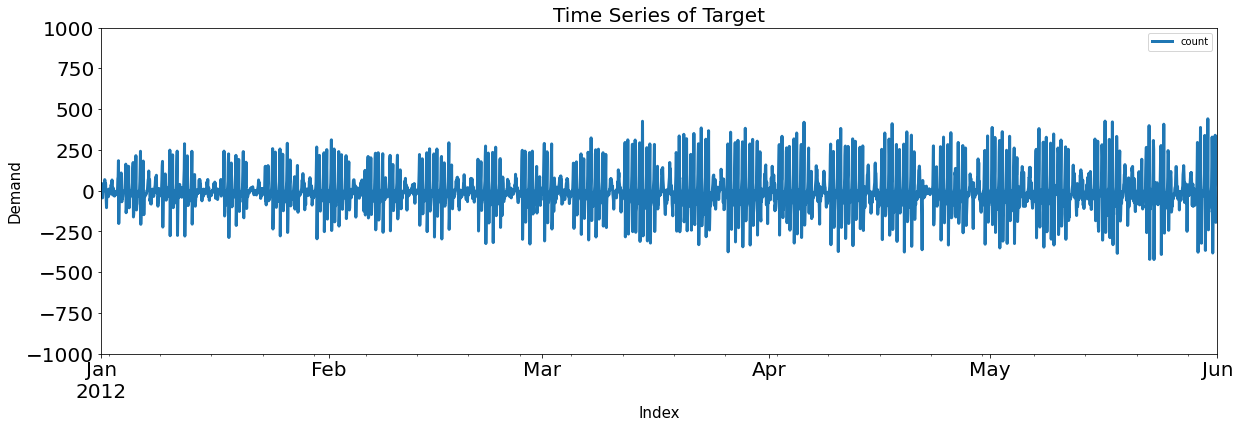

In [67]:
# line plot of Y for specific periods
raw_all[['count']].diff().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2012-01-01', '2012-06-01'), ylim=(-1000,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [68]:
# diff of Y and merging
Y_diff = raw_all[['count']].diff()
Y_diff.fillna(method='ffill', inplace=True)
Y_diff.fillna(method='bfill', inplace=True)
Y_diff.columns = ['count_diff']
if 'count_diff' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_diff], axis=1)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff
DateTime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70,110.17,73.30,-3.00
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48,110.88,73.70,-30.00
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10,112.67,74.10,1.00


In [69]:
raw_all[['temp']]
pd.cut(raw_all['temp'], 5)

DateTime
2011-01-01 00:00:00    (8.856, 16.892]
2011-01-01 01:00:00    (8.856, 16.892]
2011-01-01 02:00:00    (8.856, 16.892]
2011-01-01 03:00:00    (8.856, 16.892]
2011-01-01 04:00:00    (8.856, 16.892]
                            ...       
2012-12-31 19:00:00    (8.856, 16.892]
2012-12-31 20:00:00    (8.856, 16.892]
2012-12-31 21:00:00    (8.856, 16.892]
2012-12-31 22:00:00    (8.856, 16.892]
2012-12-31 23:00:00    (8.856, 16.892]
Freq: H, Name: temp, Length: 17544, dtype: category
Categories (5, interval[float64, right]): [(0.78, 8.856] < (8.856, 16.892] < (16.892, 24.928] < (24.928, 32.964] < (32.964, 41.0]]

In [70]:
# split values as some group
raw_all['temp_group'] = pd.cut(raw_all['temp'], 10)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group
DateTime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]"
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]"
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]"
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]"
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70,110.17,73.30,-3.00,"(8.856, 12.874]"
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48,110.88,73.70,-30.00,"(8.856, 12.874]"
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10,112.67,74.10,1.00,"(8.856, 12.874]"


In [72]:
raw_all.dtypes

datetime          datetime64[ns]
season                     int64
holiday                    int64
workingday                 int64
weather                    int64
                       ...      
count_seasonal           float64
count_Day                float64
count_Week               float64
count_diff               float64
temp_group              category
Length: 18, dtype: object

In [73]:
raw_all.describe().T
raw_all.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29 00:00:00,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaN,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaN,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
count_seasonal,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.00,128.50,-181.67,-117.81,21.32,64.69,273.37
count_Day,"17,544.00",NaN,NaN,NaN,NaT,NaT,187.74,80.25,18.04,130.29,188.48,247.42,382.50
count_Week,"17,544.00",NaN,NaN,NaN,NaT,NaT,187.67,73.12,45.95,137.19,185.83,254.88,332.99
count_diff,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.00,100.90,-523.00,-39.00,-4.00,30.00,519.00


In [74]:
# raw_all.isnull()
raw_all.isnull().sum().sum()

0

In [76]:
raw_all.datetime.dt.year

DateTime
2011-01-01 00:00:00    2011
2011-01-01 01:00:00    2011
2011-01-01 02:00:00    2011
2011-01-01 03:00:00    2011
2011-01-01 04:00:00    2011
                       ... 
2012-12-31 19:00:00    2012
2012-12-31 20:00:00    2012
2012-12-31 21:00:00    2012
2012-12-31 22:00:00    2012
2012-12-31 23:00:00    2012
Freq: H, Name: datetime, Length: 17544, dtype: int64

In [77]:
raw_all['Year'] = raw_all.datetime.dt.year
raw_all['Quater'] = raw_all.datetime.dt.quarter
raw_all.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater
count,"17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00"
mean,2.50,0.03,0.68,1.43,20.30,23.71,62.87,12.81,35.35,152.44,187.80,187.79,0.00,187.74,187.67,0.00,"2,011.50",2.51
std,1.11,0.17,0.47,0.65,7.92,8.62,19.34,8.29,49.19,151.28,181.35,80.16,128.50,80.25,73.12,100.90,0.50,1.12
min,1.00,0.00,0.00,1.00,0.82,0.00,0.00,0.00,0.00,0.00,1.00,18.06,-181.67,18.04,45.95,-523.00,"2,011.00",1.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,48.00,7.00,4.00,32.00,38.00,130.56,-117.81,130.29,137.19,-39.00,"2,011.00",2.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,63.00,13.00,16.00,114.00,140.00,188.47,21.32,188.48,185.83,-4.00,"2,012.00",3.00
75%,3.00,0.00,1.00,2.00,27.06,31.06,79.00,17.00,48.00,219.00,279.00,247.46,64.69,247.42,254.88,30.00,"2,012.00",4.00
max,4.00,1.00,1.00,4.00,41.00,50.00,100.00,57.00,367.00,886.00,977.00,379.06,273.37,382.50,332.99,519.00,"2,012.00",4.00


In [78]:
# quater -> 년도 구분을 위한 dummy
raw_all['Quater_ver2'] = raw_all['Quater'] + (raw_all.Year - raw_all.Year.min()) * 4
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group,Year,Quater,Quater_ver2
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,16,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,40,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,32,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]",2011,1,1
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,13,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]",2011,1,1
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]",2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,119,113.71,122.70,110.17,73.30,-3.00,"(8.856, 12.874]",2012,4,8
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,89,113.71,37.48,110.88,73.70,-30.00,"(8.856, 12.874]",2012,4,8
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,90,113.71,-16.10,112.67,74.10,1.00,"(8.856, 12.874]",2012,4,8


In [79]:
# feature extraction of time information
raw_all['Month'] = raw_all.datetime.dt.month
raw_all['Day'] = raw_all.datetime.dt.day
raw_all['Hour'] = raw_all.datetime.dt.hour
raw_all['DayofWeek'] = raw_all.datetime.dt.dayofweek
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count_Week,count_diff,temp_group,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,0,5
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,1,5
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,56.11,-8.00,"(8.856, 12.874]",2011,1,1,1,1,2,5
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,56.11,-19.00,"(8.856, 12.874]",2011,1,1,1,1,3,5
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,56.11,-12.00,"(8.856, 12.874]",2011,1,1,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,73.30,-3.00,"(8.856, 12.874]",2012,4,8,12,31,19,0
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,73.70,-30.00,"(8.856, 12.874]",2012,4,8,12,31,20,0
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,74.10,1.00,"(8.856, 12.874]",2012,4,8,12,31,21,0


In [81]:
raw_all.info()
raw_all.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        17544 non-null  datetime64[ns]
 1   season          17544 non-null  int64         
 2   holiday         17544 non-null  int64         
 3   workingday      17544 non-null  int64         
 4   weather         17544 non-null  int64         
 5   temp            17544 non-null  float64       
 6   atemp           17544 non-null  float64       
 7   humidity        17544 non-null  int64         
 8   windspeed       17544 non-null  float64       
 9   casual          17544 non-null  int64         
 10  registered      17544 non-null  int64         
 11  count           17544 non-null  int64         
 12  count_trend     17544 non-null  float64       
 13  count_seasonal  17544 non-null  float64       
 14  count_Day  

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29 00:00:00,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaN,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaN,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Quater_ver2,"17,544.00",NaN,NaN,NaN,NaT,NaT,4.51,2.29,1.00,3.00,5.00,7.00,8.00
Month,"17,544.00",NaN,NaN,NaN,NaT,NaT,6.52,3.45,1.00,4.00,7.00,10.00,12.00
Day,"17,544.00",NaN,NaN,NaN,NaT,NaT,15.74,8.80,1.00,8.00,16.00,23.00,31.00
Hour,"17,544.00",NaN,NaN,NaN,NaT,NaT,11.51,6.94,0.00,5.00,12.00,17.25,23.00


## 지연값 lag

In [85]:
raw_all['count'].shift(2)

DateTime
2011-01-01 00:00:00      NaN
2011-01-01 01:00:00      NaN
2011-01-01 02:00:00    16.00
2011-01-01 03:00:00    40.00
2011-01-01 04:00:00    32.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count, Length: 17544, dtype: float64

In [86]:
# calculation of lags of Y
raw_all['count_lag1'] = raw_all['count'].shift(1)
raw_all['count_lag2'] = raw_all['count'].shift(2)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_group,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,"(8.856, 12.874]",2011,1,1,1,1,0,5,NaN,NaN
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,"(8.856, 12.874]",2011,1,1,1,1,1,5,16.00,NaN
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,"(8.856, 12.874]",2011,1,1,1,1,2,5,40.00,16.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,"(8.856, 12.874]",2011,1,1,1,1,3,5,32.00,40.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,"(8.856, 12.874]",2011,1,1,1,1,4,5,13.00,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,"(8.856, 12.874]",2012,4,8,12,31,19,0,122.00,164.00
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,"(8.856, 12.874]",2012,4,8,12,31,20,0,119.00,122.00
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,"(8.856, 12.874]",2012,4,8,12,31,21,0,89.00,119.00


In [87]:
raw_all['count_lag2'].fillna(0)

DateTime
2011-01-01 00:00:00     0.00
2011-01-01 01:00:00     0.00
2011-01-01 02:00:00    16.00
2011-01-01 03:00:00    40.00
2011-01-01 04:00:00    32.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count_lag2, Length: 17544, dtype: float64

In [88]:
raw_all['count_lag1'].fillna(method='bfill', inplace=True)
raw_all['count_lag2'].fillna(method='bfill', inplace=True)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_group,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,"(8.856, 12.874]",2011,1,1,1,1,0,5,16.00,16.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,"(8.856, 12.874]",2011,1,1,1,1,1,5,16.00,16.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,"(8.856, 12.874]",2011,1,1,1,1,2,5,40.00,16.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,"(8.856, 12.874]",2011,1,1,1,1,3,5,32.00,40.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,"(8.856, 12.874]",2011,1,1,1,1,4,5,13.00,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,"(8.856, 12.874]",2012,4,8,12,31,19,0,122.00,164.00
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,"(8.856, 12.874]",2012,4,8,12,31,20,0,119.00,122.00
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,"(8.856, 12.874]",2012,4,8,12,31,21,0,89.00,119.00


## dummy 변수.

In [91]:
pd.get_dummies(raw_all['Quater'])
pd.get_dummies(raw_all['Quater'], prefix="Quater_dummy")
pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,8,12,31,21,0,89.00,119.00,0,0,1


In [92]:
# feature extraction using dummy variables
if 'Quater' in raw_all.columns:
    raw_all = pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
], axis=1)
    del raw_all['Quater']
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,8,12,31,21,0,89.00,119.00,0,0,1


In [95]:
result = []

for col in raw_all.columns:
    if col != 'temp_group':
        result.append(col)
result

# is same as
#[col for col in raw_all.columns if col != 'temp_group']


['datetime',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'count',
 'count_trend',
 'count_seasonal',
 'count_Day',
 'count_Week',
 'count_diff',
 'Year',
 'Quater_ver2',
 'Month',
 'Day',
 'Hour',
 'DayofWeek',
 'count_lag1',
 'count_lag2',
 'Quater_Dummy_2',
 'Quater_Dummy_3',
 'Quater_Dummy_4']

In [102]:
raw_all.loc[:].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        17544 non-null  datetime64[ns]
 1   season          17544 non-null  int64         
 2   holiday         17544 non-null  int64         
 3   workingday      17544 non-null  int64         
 4   weather         17544 non-null  int64         
 5   temp            17544 non-null  float64       
 6   atemp           17544 non-null  float64       
 7   humidity        17544 non-null  int64         
 8   windspeed       17544 non-null  float64       
 9   casual          17544 non-null  int64         
 10  registered      17544 non-null  int64         
 11  count           17544 non-null  int64         
 12  count_trend     17544 non-null  float64       
 13  count_seasonal  17544 non-null  float64       
 14  count_Day  

In [100]:
raw_all.loc[:,result]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,8,12,31,21,0,89.00,119.00,0,0,1


In [104]:
raw_all.loc[:, [col for col in raw_all.columns if col != 'temp_group']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        17544 non-null  datetime64[ns]
 1   season          17544 non-null  int64         
 2   holiday         17544 non-null  int64         
 3   workingday      17544 non-null  int64         
 4   weather         17544 non-null  int64         
 5   temp            17544 non-null  float64       
 6   atemp           17544 non-null  float64       
 7   humidity        17544 non-null  int64         
 8   windspeed       17544 non-null  float64       
 9   casual          17544 non-null  int64         
 10  registered      17544 non-null  int64         
 11  count           17544 non-null  int64         
 12  count_trend     17544 non-null  float64       
 13  count_seasonal  17544 non-null  float64       
 14  count_Day  

## code summary functionalize

In [105]:
### Feature engineering of default
def non_feature_engineering(raw):
    raw_nfe = raw.copy()
    if 'datetime' in raw_nfe.columns:
        raw_nfe['datetime'] = pd.to_datetime(raw_nfe['datetime'])
        raw_nfe['DateTime'] = pd.to_datetime(raw_nfe['datetime'])
    if raw_nfe.index.dtype == 'int64':
        raw_nfe.set_index('DateTime', inplace=True)
    # bring back
    # if raw_nfe.index.dtype != 'int64':
    #     raw_nfe.reset_index(drop=False, inplace=True)
    raw_nfe = raw_nfe.asfreq('H', method='ffill')
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Week], axis=1)

    Y_diff = raw_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)
    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min()) * 4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            raw_fe = pd.concat([raw_fe, pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw_fe['Quater']
    return raw_fe

In [107]:
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_new = pd.read_csv(location)
raw_new

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61


In [109]:
raw_nfe = non_feature_engineering(raw_new)
raw_nfe

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90


In [111]:
raw_fe = feature_engineering(raw_new)
raw_fe

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,8,12,31,21,0,89.00,119.00,0,0,1
